# Robot - Feature engineering on sensor data

The purpose of this notebook is to illustrate how we can overcome the feature explosion problem based on an example dataset involving sensor data.

Summary:

- Prediction type: __Regression__
- Domain: __Robotics__
- Prediction target: __The force vector on the robot's arm__ 
- Population size: __15001__

## Feature explosion 

### The problem

The feature explosion problem is one of the most important issues in automated feature engineering. In fact, it is probably the main reason why automated feature engineering is not already the norm in data science projects involving business data.

To illustrate the problem, consider how data scientists write features for a simple time series problem:

```sql
SELECT SOME_AGGREGATION(t2.some_column)
FROM some_table t1
LEFT JOIN some_table t2
ON t1.join_key = t2.join_key
WHERE t2.some_other_column >= some_value
AND t2.rowid <= t1.rowid
AND t2.rowid + some_other_value > t1.rowid
GROUP BY t1.rowid;
```

Think about that for a second. 

Every column that we have can either be aggregated (*some_column*) or it can be used for our conditions (*some_other_column*). That means if we have *n* columns to aggregate, we can potentially build conditions for $n$ other columns. In other words, the computational complexity is $n^2$ in the number of columns.

Note that this problem occurs regardless of whether you automate feature engineering or you do it by hand. The size of the search space is $n^2$ in the number of columns in either case, unless you can rule something out a-priori.

This problem is known as _feature explosion_.

### The solution

So when we have relational data or time series with many columns, what do we do? The answer is to write different features. Specifically, suppose we had features like this:

```sql
SELECT SOME_AGGREGATION(
    CASE 
         WHEN t2.some_column > some_value THEN weight1
         WHEN t2.some_column <= some_value THEN weight2
    END
)
FROM some_table t1
LEFT JOIN some_table t2
ON t1.join_key = t2.join_key
WHERE t2.rowid <= t1.rowid
AND t2.rowid + some_other_value > t1.rowid
GROUP BY t1.rowid;
```

*weight1* and *weight2* are learnable weights. An algorithm that generates features like this can only use columns for conditions, it is not allowed to aggregate columns – and it doesn't need to do so.

That means the computational complexity is linear instead of quadratic. For data sets with a large number of columns this can make all the difference in the world. For instance, if you have 100 columns the size of the search space of the second approach is only 1% of the size of the search space of the first one.

getML features an algorithm called *relboost*, which generates features according to this principle and is therefore very suitable for data sets with many columns.

### The data set

To illustrate the problem, we use a data set related to robotics. When robots interact with humans, the most important think is that they don't hurt people. In order to prevent such accidents, the *force vector* on the robot's arm is measured. However, measuring the force vector is expensive.

Therefore, we want consider an alternative approach. We would like to predict the force vector based on other sensor data that are less costly to measure. To do so, we use *machine learning*.

However, the data set contains measurements from almost 100 different sensors and we do not know which and how many sensors are relevant for predicting the force vector.

The data set has been generously provided by Erik Berger who originally collected it for his dissertation:

> Berger, E. (2018). *Behavior-Specific Proprioception Models for Robotic Force Estimation: A Machine Learning Approach.* Freiberg, Germany: Technische Universitaet Bergakademie Freiberg.

## 1. Loading data

We begin by importing the libraries and setting the project.

In [1]:
!pip install -q "getml==1.5.0" "matplotlib==3.9.2" "ipywidgets==8.1.5"

In [2]:
import matplotlib.pyplot as plt

import getml

%matplotlib inline  

print(f"getML API version: {getml.__version__}\n")

getML API version: 1.5.0



In [34]:
getml.engine.launch(allow_remote_ips=True, token='token')
getml.engine.set_project('robot')

Launching ./getML --allow-push-notifications=true --allow-remote-ips=true --home-directory=/home/user --in-memory=true --install=false --launch-browser=true --log=false --token=token in /home/user/.getML/getml-1.5.0-x64-linux...
Launched the getML Engine. The log output will be stored in /home/user/.getML/logs/20240912154610.log.
  Loading pipelines... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00


Connected to project 'robot'.

### 1.1 Download from source


In [4]:
data_all = getml.data.DataFrame.from_csv(
    "https://static.getml.com/datasets/robotarm/robot-demo.csv", 
    "data_all"
)

In [5]:
data_all

name              3              4              5              6   ...            105            106            f_x
 role   unused_float   unused_float   unused_float   unused_float   ...   unused_float   unused_float   unused_float
    0         3.4098        -0.3274         0.9604        -3.7436   ...         47.955         47.971        -11.03 
    1         3.4098        -0.3274         0.9604        -3.7436   ...         47.955         47.971        -10.848
    2         3.4098        -0.3274         0.9604        -3.7436   ...         47.955         47.971        -10.666
    3         3.4098        -0.3274         0.9604        -3.7436   ...         47.955         47.971        -10.507
    4         3.4098        -0.3274         0.9604        -3.7436   ...         47.955         47.971        -10.413
             ...            ...            ...            ...                   ...            ...            ...   
14996         3.0837        -0.8836         1.4501        -2.2102   ...         47.94          47.94          10.84 
14997         3.0835        -0.884          1.4505        -2.2091   ...         47.94          47.94          10.857
14998         3.0833        -0.8844         1.4508        -2.208    ...         47.94          47.94          10.89 
14999         3.0831        -0.8847         1.4511        -2.2071   ...         47.94          47.94          11.29 
15000         3.0829        -0.885          1.4514        -2.2062   ...         47.94          47.955         11.69 

 name            f_y            f_z
 role   unused_float   unused_float
    0         6.9           -7.33  
    1         6.7218        -7.4427
    2         6.5436        -7.5555
    3         6.4533        -7.65  
    4         6.6267        -7.69  
             ...            ...    
14996        -1.41          16.14  
14997        -1.52          15.943 
14998        -1.74          15.55  
14999        -1.4601        15.743 
15000        -1.1801        15.937 


15001 rows x 96 columns
memory usage: 11.52 MB
type: getml.DataFrame

### 1.2 Prepare data for getML

The force vector consists of three component (*f_x*, *f_y* and *f_z*), meaning that we have three targets.

In [6]:
data_all.set_role(["f_x", "f_y", "f_z"], getml.data.roles.target)
data_all.set_role(data_all.roles.unused, getml.data.roles.numerical)

This is what the data set looks like:

In [7]:
data_all

name       f_x       f_y       f_z           3   ...         102         103         104         105         106
 role    target    target    target   numerical   ...   numerical   numerical   numerical   numerical   numerical
    0   -11.03     6.9      -7.33        3.4098   ...      47.925      47.818      47.834      47.955      47.971
    1   -10.848    6.7218   -7.4427      3.4098   ...      47.925      47.818      47.834      47.955      47.971
    2   -10.666    6.5436   -7.5555      3.4098   ...      47.925      47.818      47.834      47.955      47.971
    3   -10.507    6.4533   -7.65        3.4098   ...      47.925      47.818      47.834      47.955      47.971
    4   -10.413    6.6267   -7.69        3.4098   ...      47.925      47.818      47.834      47.955      47.971
         ...      ...       ...         ...                ...         ...         ...         ...         ...   
14996    10.84    -1.41     16.14        3.0837   ...      47.834      47.818      47.803      47.94       47.94 
14997    10.857   -1.52     15.943       3.0835   ...      47.834      47.818      47.803      47.94       47.94 
14998    10.89    -1.74     15.55        3.0833   ...      47.834      47.818      47.803      47.94       47.94 
14999    11.29    -1.4601   15.743       3.0831   ...      47.834      47.818      47.803      47.94       47.94 
15000    11.69    -1.1801   15.937       3.0829   ...      47.834      47.818      47.803      47.94       47.955


15001 rows x 96 columns
memory usage: 11.52 MB
type: getml.DataFrame

### 1.3 Separate data into a training and testing set

We also want to separate the data set into a training and testing set. We do so by using the first 10,500 measurements for training and then using the remainder for testing.

In [8]:
split = getml.data.split.time(data_all, "rowid", test=10500)
split

,
0,train
1,train
2,train
3,train
4,train
,...


In [9]:
time_series = getml.data.TimeSeries(
    population=data_all,
    split=split,
    time_stamps="rowid",
    lagged_targets=False,
    memory=30,
)

time_series

data model

  population:
    columns:
    - 3: numerical
    - 4: numerical
    - 5: numerical
    - 6: numerical
    - 7: numerical
    - ...

    joins:
    - right: 'data_all'
      time_stamps: (population.rowid, data_all.rowid)
      relationship: 'many-to-many'
      memory: 30
      lagged_targets: False

  data_all:
    columns:
    - 3: numerical
    - 4: numerical
    - 5: numerical
    - 6: numerical
    - 7: numerical
    - ...


container

  population
      subset   name        rows   type
  0   test     data_all    4501   View
  1   train    data_all   10500   View

  peripheral
      name        rows   type
  0   data_all   15001   View

## 2. Predictive modeling

### 2.1 Building the pipeline

We then build a pipeline based on the *relboost* algorithm with *xgboost* as our predictor.

In [10]:
relboost = getml.feature_learning.Relboost(
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    num_features=10,
)

xgboost = getml.predictors.XGBoostRegressor()

pipe1 = getml.pipeline.Pipeline(
    data_model=time_series.data_model,
    feature_learners=[relboost],
    predictors=xgboost
)

It is always a good idea to check the pipeline for any potential issues.

In [11]:
pipe1.check(time_series.train)

Checking data model...

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Checking... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00


OK.

### 2.2 Fitting the pipeline

In [12]:
pipe1.fit(time_series.train)

Checking data model...

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00


OK.

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Relboost: Training features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:32
  Relboost: Training features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:34
  Relboost: Training features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:34
  Relboost: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:08
  Relboost: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:07
  Relboost: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:07
  XGBoost: Training as predictor... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:03
  XGBoost: Training as predictor... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:03
  XGBoost: Training as predictor... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:04


Trained pipeline.

Time taken: 0:02:16.080596.



Pipeline(data_model='population',
         feature_learners=['Relboost'],
         feature_selectors=[],
         include_categorical=False,
         loss_function='SquareLoss',
         peripheral=['data_all'],
         predictors=['XGBoostRegressor'],
         preprocessors=[],
         share_selected_features=0.5,
         tags=['container-cETtgf'])

### 2.3 Evaluating the pipeline

In [13]:
pipe1.score(time_series.test)

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Relboost: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:03
  Relboost: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:03
  Relboost: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:03


,date time,set used,target,mae,rmse,rsquared
0,2024-09-12 15:44:28,train,f_x,0.4467,0.5882,0.9961
1,2024-09-12 15:44:28,train,f_y,0.511,0.675,0.9895
2,2024-09-12 15:44:28,train,f_z,0.2724,0.3544,0.9988
3,2024-09-12 15:44:40,test,f_x,0.5649,0.7368,0.995
4,2024-09-12 15:44:40,test,f_y,0.564,0.7535,0.9871
5,2024-09-12 15:44:40,test,f_z,0.301,0.3931,0.9985


### 2.4 Feature importances

It is always a good idea to study the features the relational learning algorithm has extracted.

The feature importance is calculated by xgboost based on the improvement of the optimizing criterium at each split in the decision tree and is normalized to 100%.

Also note that we have three different target (*f_x*, *f_y* and *f_z*) and that different features are relevant for different targets.

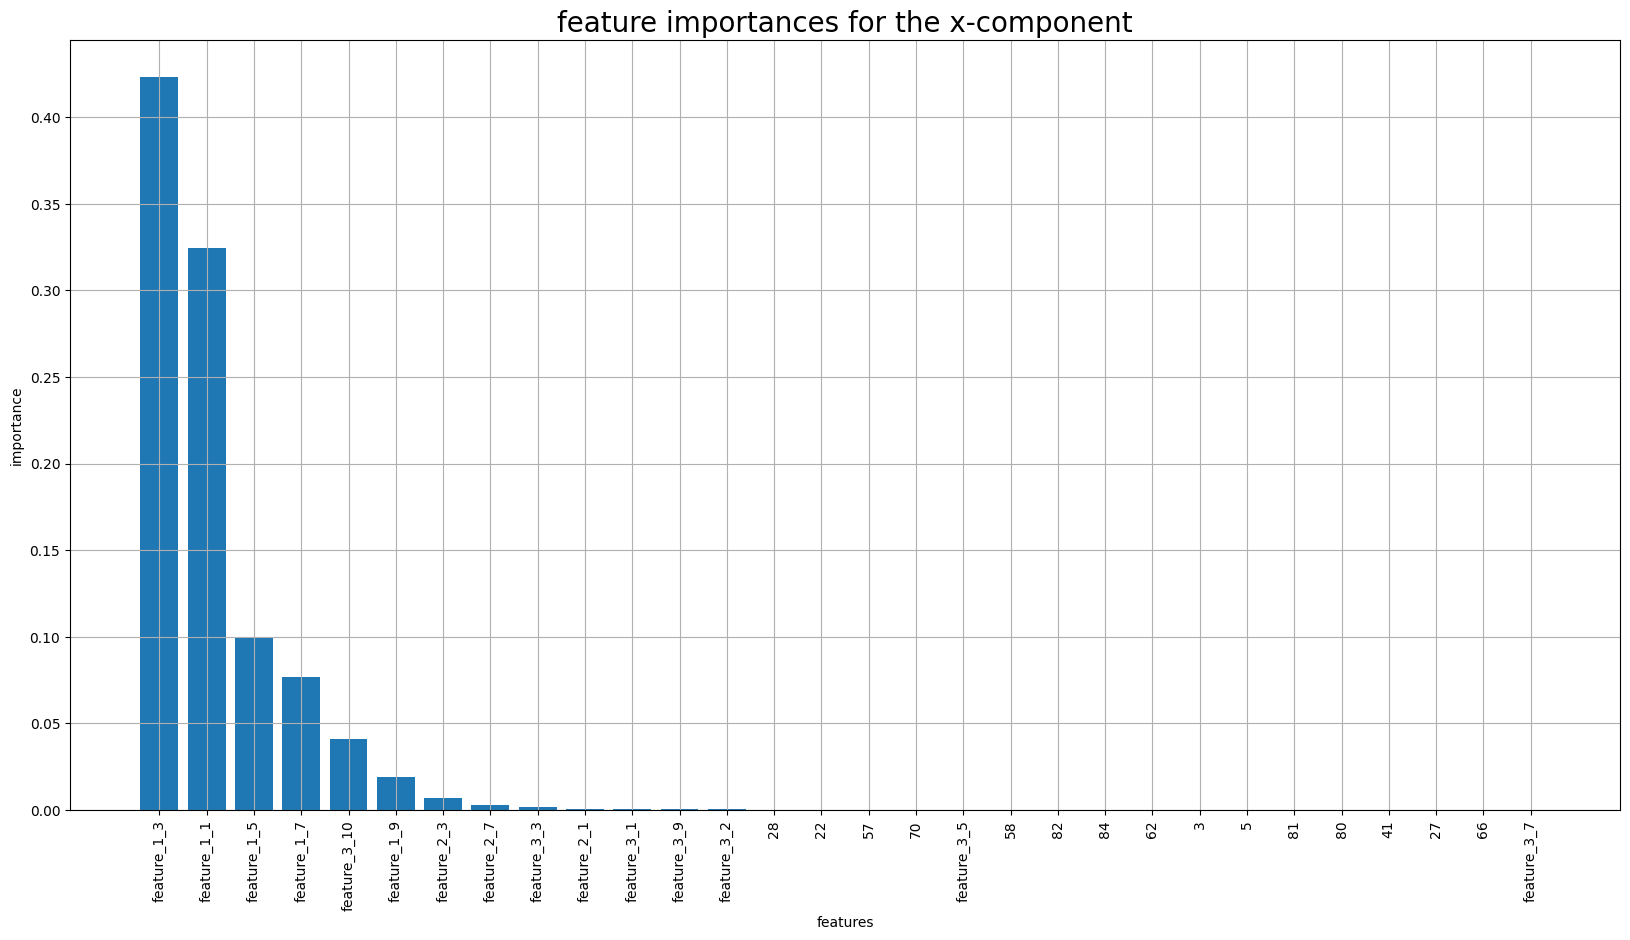

In [14]:
plt.subplots(figsize=(20, 10))

names, importances = pipe1.features.importances(target_num=0)

plt.bar(names[0:30], importances[0:30])

plt.title("feature importances for the x-component", size=20)
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

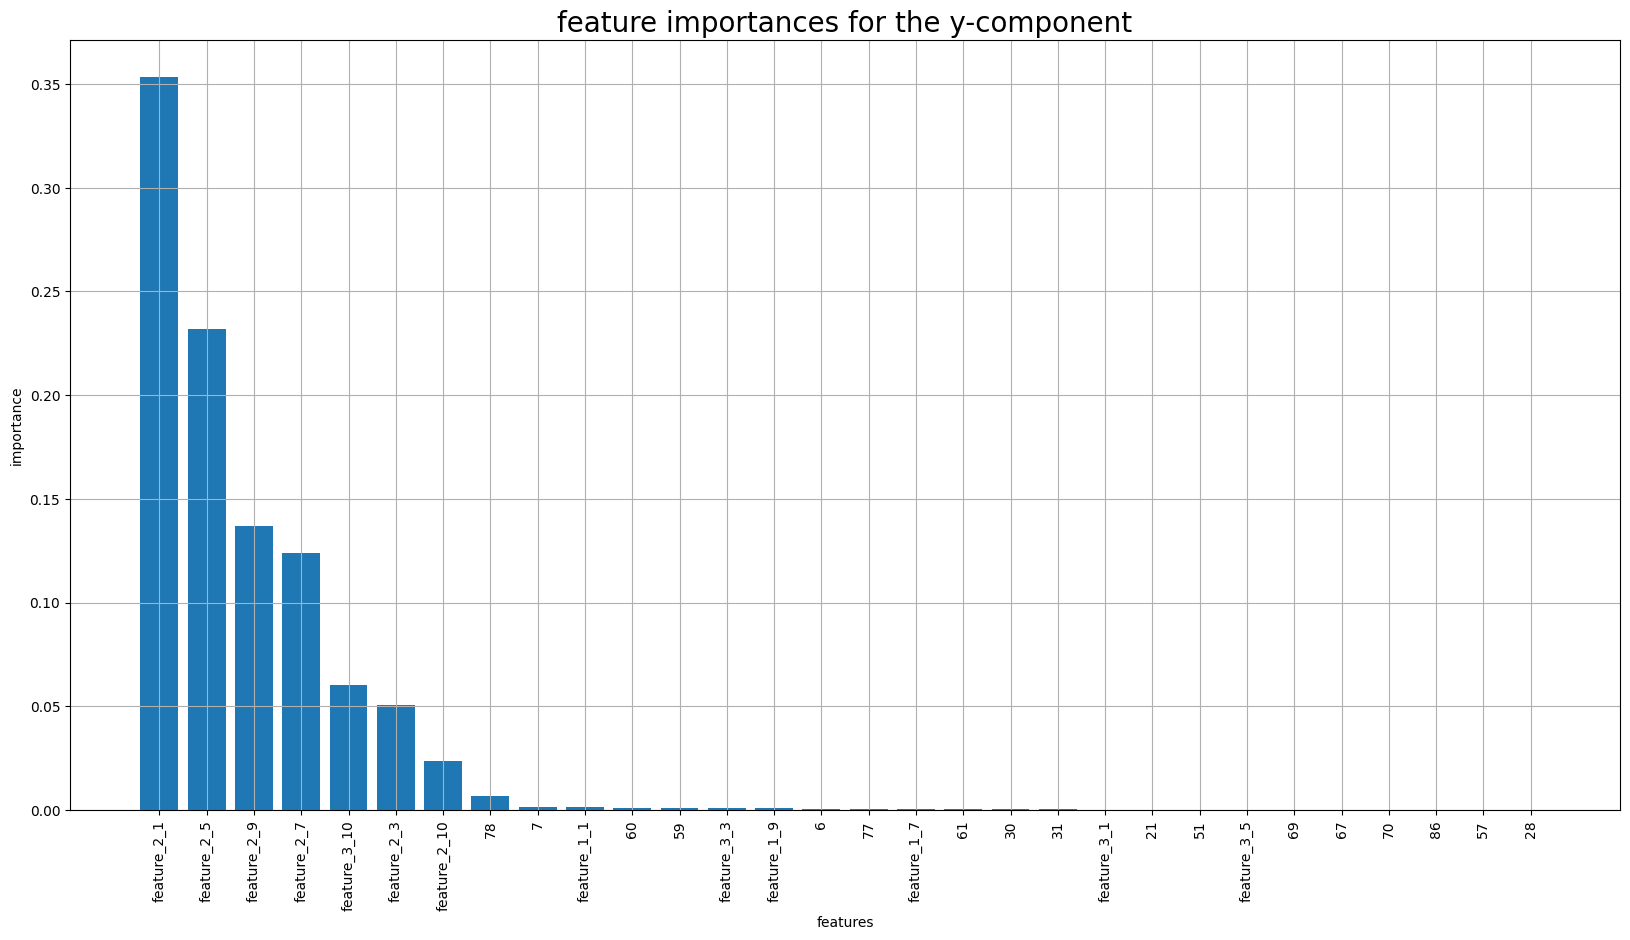

In [15]:
plt.subplots(figsize=(20, 10))

names, importances = pipe1.features.importances(target_num=1)

plt.bar(names[0:30], importances[0:30])

plt.title("feature importances for the y-component", size=20)
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

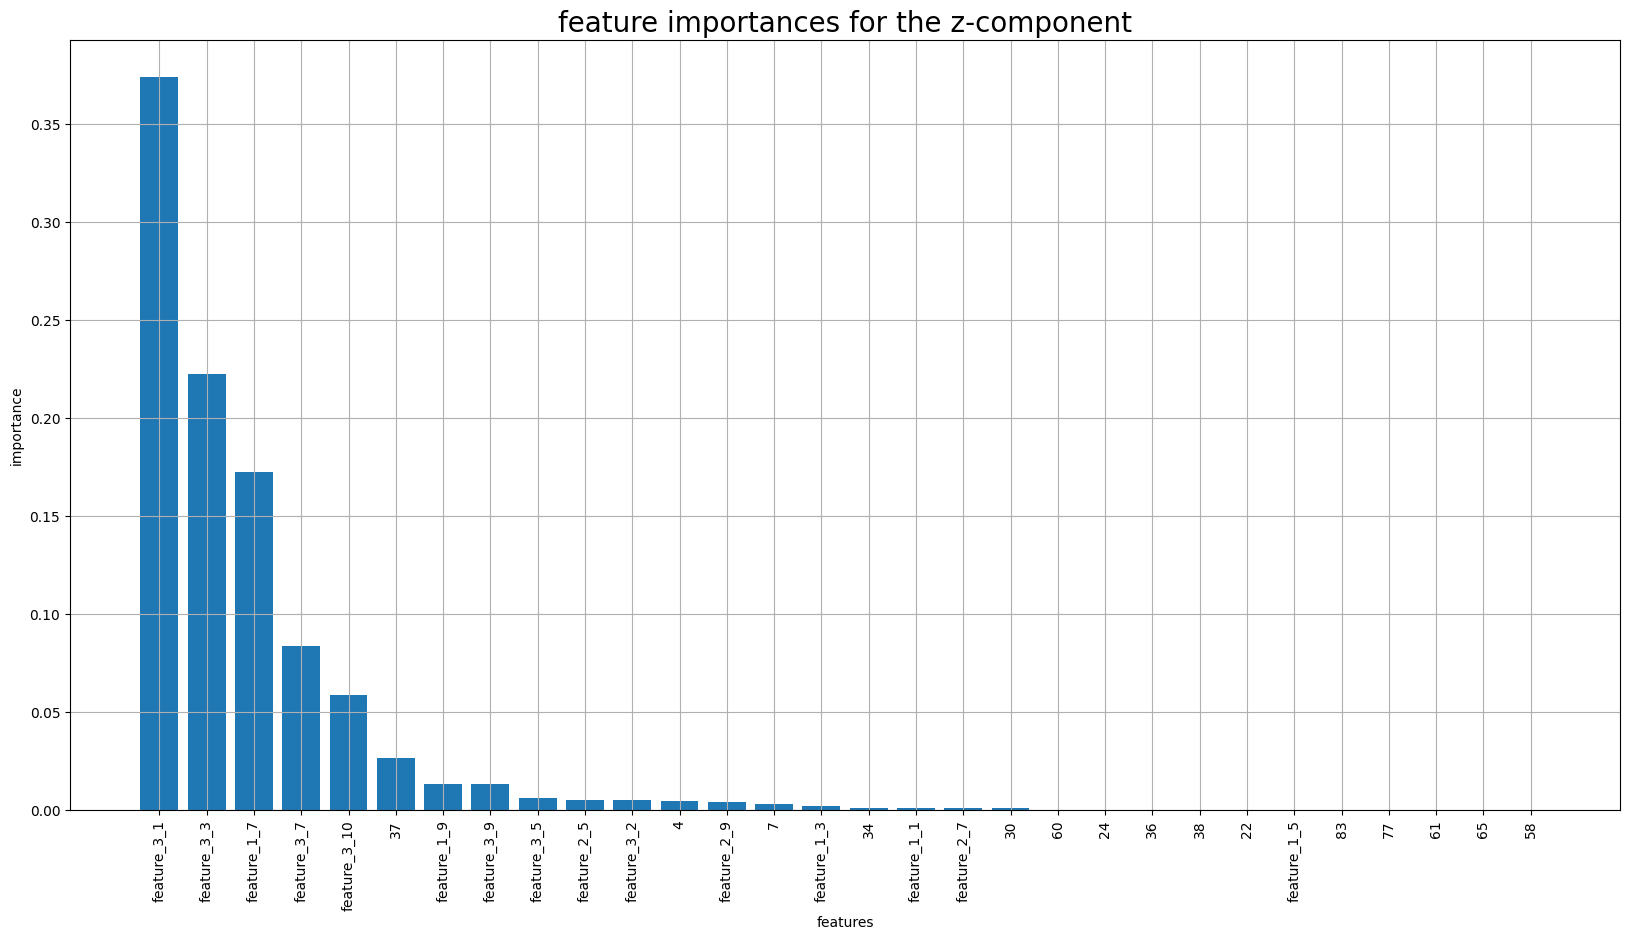

In [16]:
plt.subplots(figsize=(20, 10))

names, importances = pipe1.features.importances(target_num=2)

plt.bar(names[0:30], importances[0:30])

plt.title("feature importances for the z-component", size=20)
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

### 2.5 Column importances

Because getML is a tool for relational learning, we can also calculate the importances for the original columns, using similar methods we have used for the feature importances.

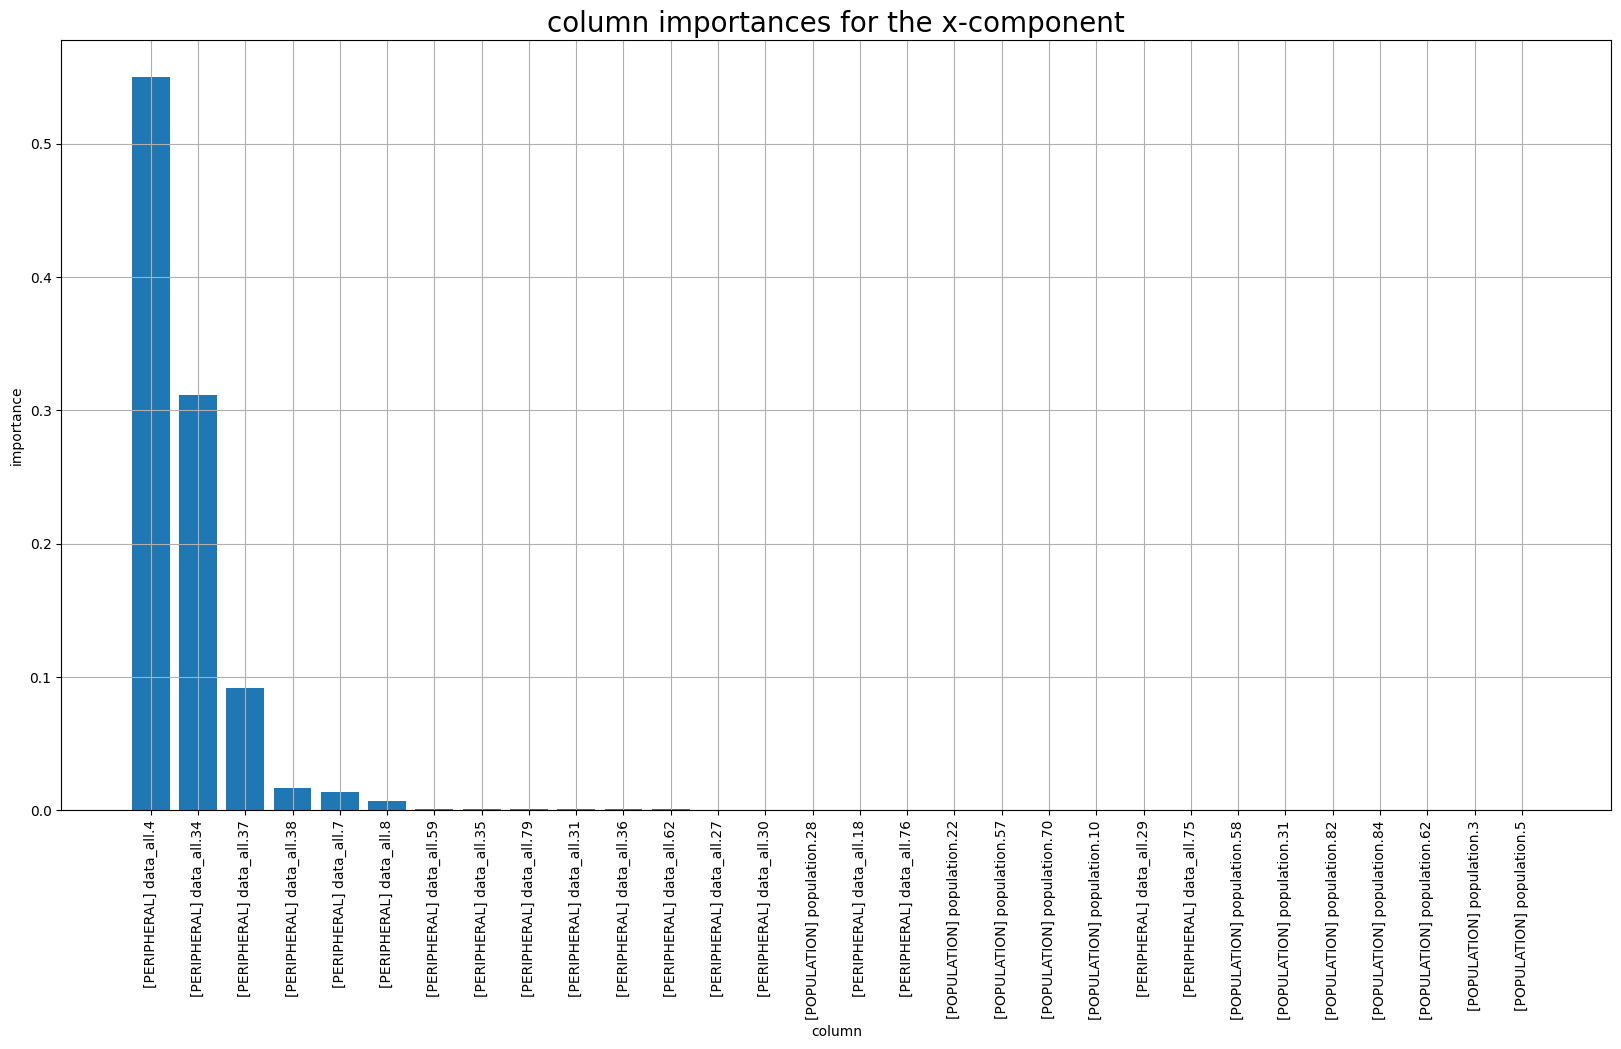

In [17]:
plt.subplots(figsize=(20, 10))

names, importances = pipe1.columns.importances(target_num=0)

plt.bar(names[0:30], importances[0:30])

plt.title("column importances for the x-component", size=20)
plt.grid(True)
plt.xlabel("column")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

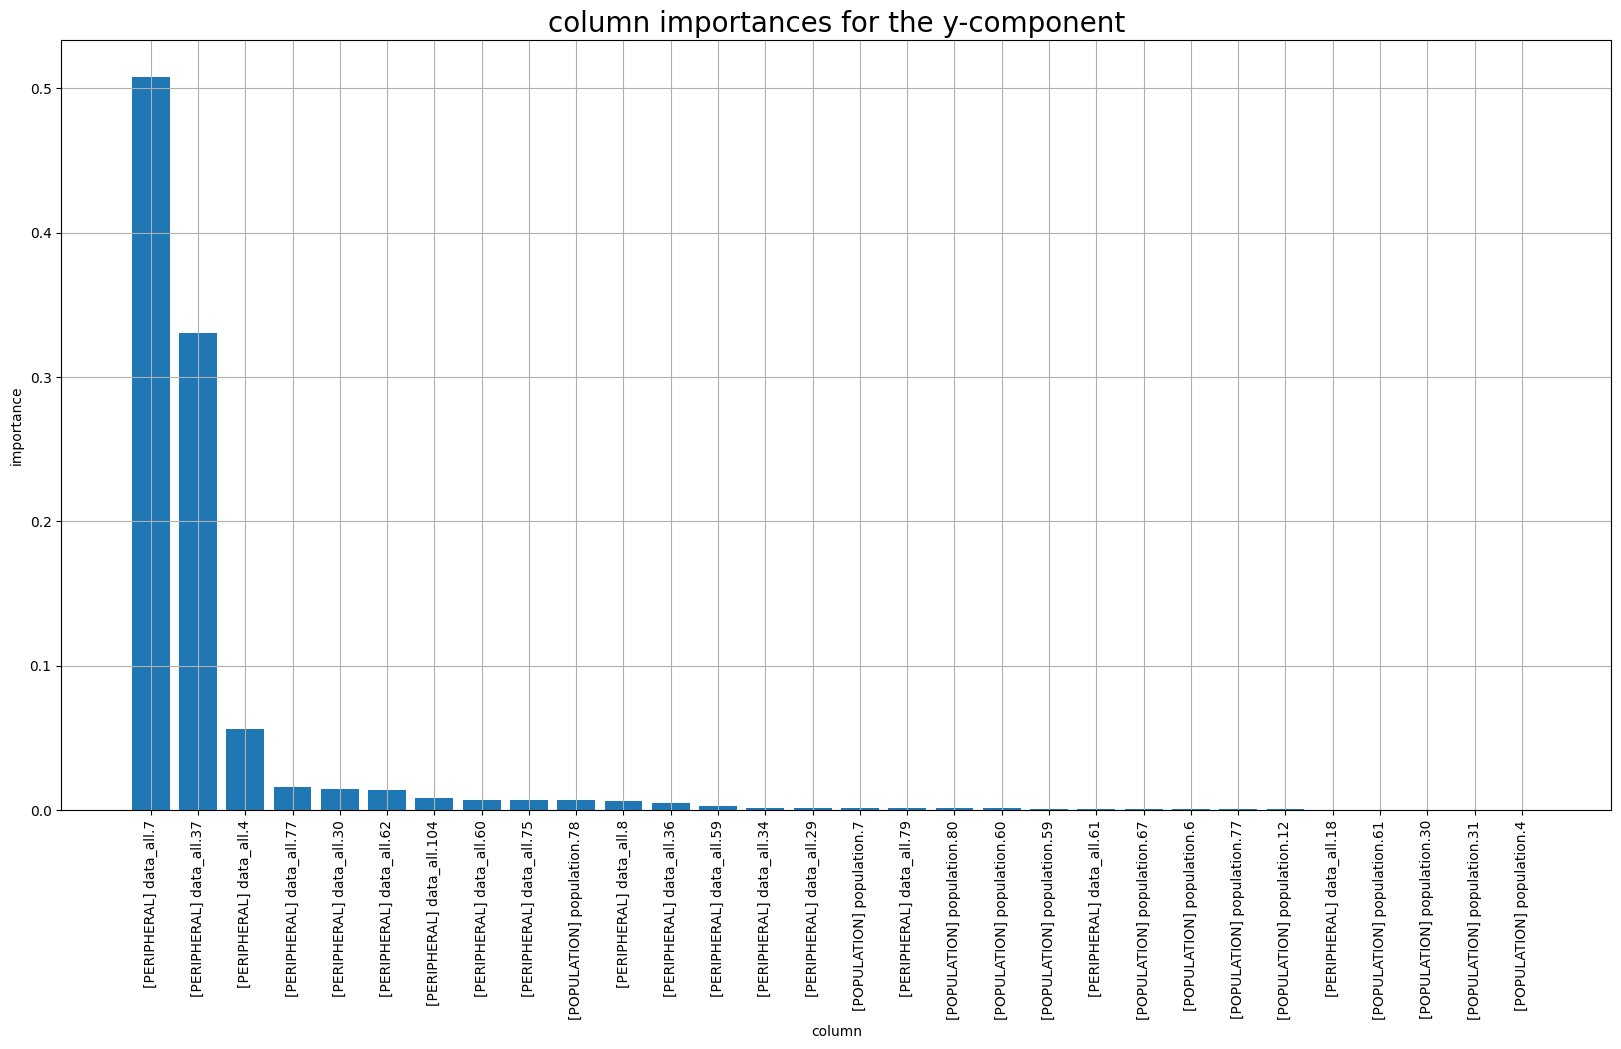

In [18]:
plt.subplots(figsize=(20, 10))

names, importances = pipe1.columns.importances(target_num=1)

plt.bar(names[0:30], importances[0:30])

plt.title("column importances for the y-component", size=20)
plt.grid(True)
plt.xlabel("column")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

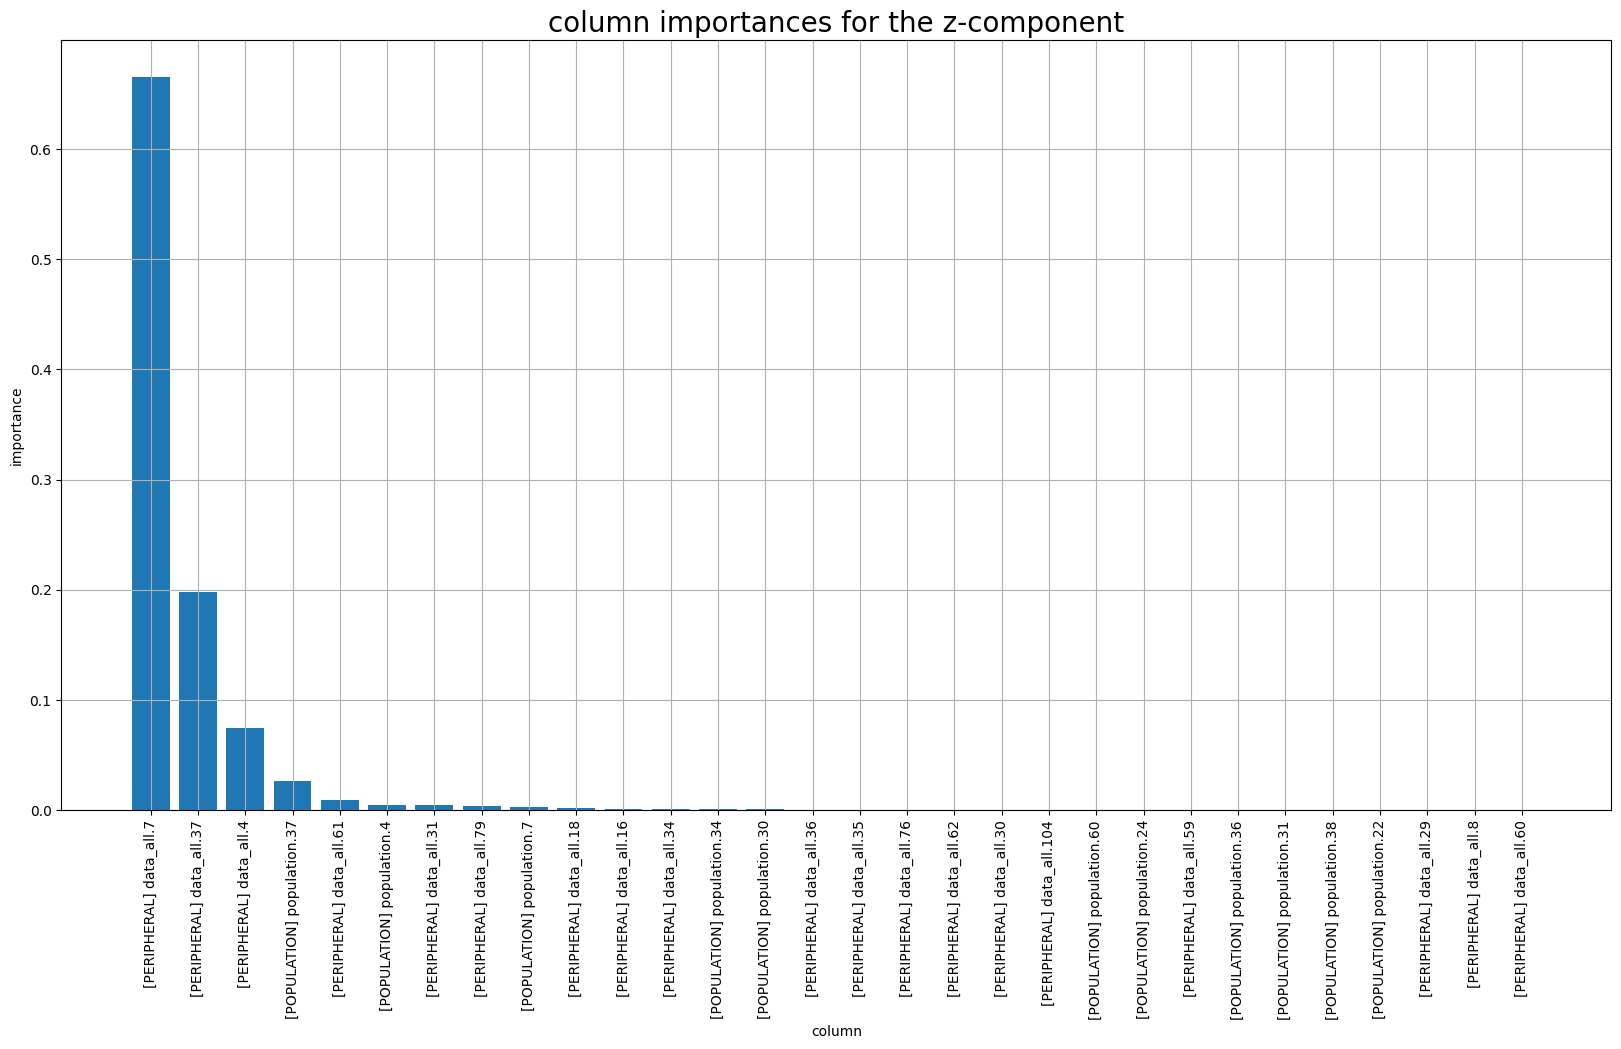

In [19]:
plt.subplots(figsize=(20, 10))

names, importances = pipe1.columns.importances(target_num=2)

plt.bar(names[0:30], importances[0:30])

plt.title("column importances for the z-component", size=20)
plt.grid(True)
plt.xlabel("column")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

### 2.6 Column selection

When we study the plots for the *column importances* we find that there are some good news. We actually don't need that many columns. About 80% of the columns contain very little predictive value.

This means that we can also apply other algorithms that are not as scalable as *relboost*. All we have to do is to select the most relevant columns:

The `.select(...)` returns a new column, in which the unimportant columns have been dropped:

In [20]:
time_series2 = pipe1.columns.select(time_series, share_selected_columns=0.35)

In [21]:
time_series2

data model

  population:
    columns:
    - 3: numerical
    - 4: numerical
    - 5: numerical
    - 6: numerical
    - 7: numerical
    - ...

    joins:
    - right: 'data_all'
      time_stamps: (population.rowid, data_all.rowid)
      relationship: 'many-to-many'
      memory: 30
      lagged_targets: False

  data_all:
    columns:
    - 3: numerical
    - 4: numerical
    - 5: numerical
    - 6: numerical
    - 7: numerical
    - ...


container

  population
      subset   name        rows   type
  0   train    data_all   10500   View
  1   test     data_all    4501   View

  peripheral
      name        rows   type
  0   data_all   15001   View

### 2.7 Fitting a second pipeline

The *multirel* algorithm does scale well do data sets with many columns. As we have discussed in the introduction, its computational complexity is $n^2$ in the number of columns. But now, we only use 35% of the original columns, meaning that it is fine to use multirel.

In [22]:
multirel = getml.feature_learning.Multirel(
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    num_features=10,
)

relboost = getml.feature_learning.Relboost(
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    num_features=10,
)

xgboost = getml.predictors.XGBoostRegressor(n_jobs=7)

pipe2 = getml.pipeline.Pipeline(
    data_model=time_series2.data_model,
    feature_learners=[multirel, relboost],
    predictors=xgboost
)

In [23]:
pipe2.check(time_series2.train)

Checking data model...

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Checking... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00


The pipeline check generated 1 issues labeled INFO and 0 issues labeled WARNING.

,type,label,message
0,INFO,MIGHT TAKE LONG,DATA_ALL__STAGING_TABLE_2 contains 23 categorical and numerical columns. Please note that columns created by the preprocessors are also part of this count. The multirel algorithm does not scale very well to data frames with many columns. This pipeline might take a very long time to fit. You should consider removing some columns or preprocessors. You could use a column selection to pick the right columns. You could also replace Multirel with Relboost or Fastboost. Both algorithms have been designed to scale well to data frames with many columns.


In [24]:
pipe2.fit(time_series2.train)

Checking data model...

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00


The pipeline check generated 1 issues labeled INFO and 0 issues labeled WARNING.

To see the issues in full, run .check() on the pipeline.

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Multirel: Training features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:08
  Relboost: Training features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:11
  Relboost: Training features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:08
  Relboost: Training features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:08
  Multirel: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:01
  Relboost: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:02
  Relboost: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:02
  Relboost: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:02
  XGBoost: Training as predictor... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  XGBoost: Training as predictor... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  XGBoost: Training as predictor... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00


Trained pipeline.

Time taken: 0:00:48.628798.



Pipeline(data_model='population',
         feature_learners=['Multirel', 'Relboost'],
         feature_selectors=[],
         include_categorical=False,
         loss_function='SquareLoss',
         peripheral=['data_all'],
         predictors=['XGBoostRegressor'],
         preprocessors=[],
         share_selected_features=0.5,
         tags=['container-5qzYt6'])

In [25]:
pipe2.score(time_series2.test)

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Multirel: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Relboost: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:01
  Relboost: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:01
  Relboost: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:01


,date time,set used,target,mae,rmse,rsquared
0,2024-09-12 15:45:31,train,f_x,0.4525,0.5984,0.996
1,2024-09-12 15:45:31,train,f_y,0.5236,0.6882,0.9891
2,2024-09-12 15:45:31,train,f_z,0.2664,0.3486,0.9988
3,2024-09-12 15:45:37,test,f_x,0.5587,0.7319,0.995
4,2024-09-12 15:45:37,test,f_y,0.5667,0.7534,0.9871
5,2024-09-12 15:45:37,test,f_z,0.2914,0.3789,0.9986


### 2.8 Visualizing the predictions

Sometimes a picture says more than a 1000 words. We therefore want to visualize our predictions on the testing set.

In [26]:
f_x = time_series2.test.population["f_x"].to_numpy()
f_y = time_series2.test.population["f_y"].to_numpy()
f_z = time_series2.test.population["f_z"].to_numpy()

In [27]:
predictions = pipe2.predict(time_series2.test)

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Multirel: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Relboost: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:01
  Relboost: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:01
  Relboost: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:01


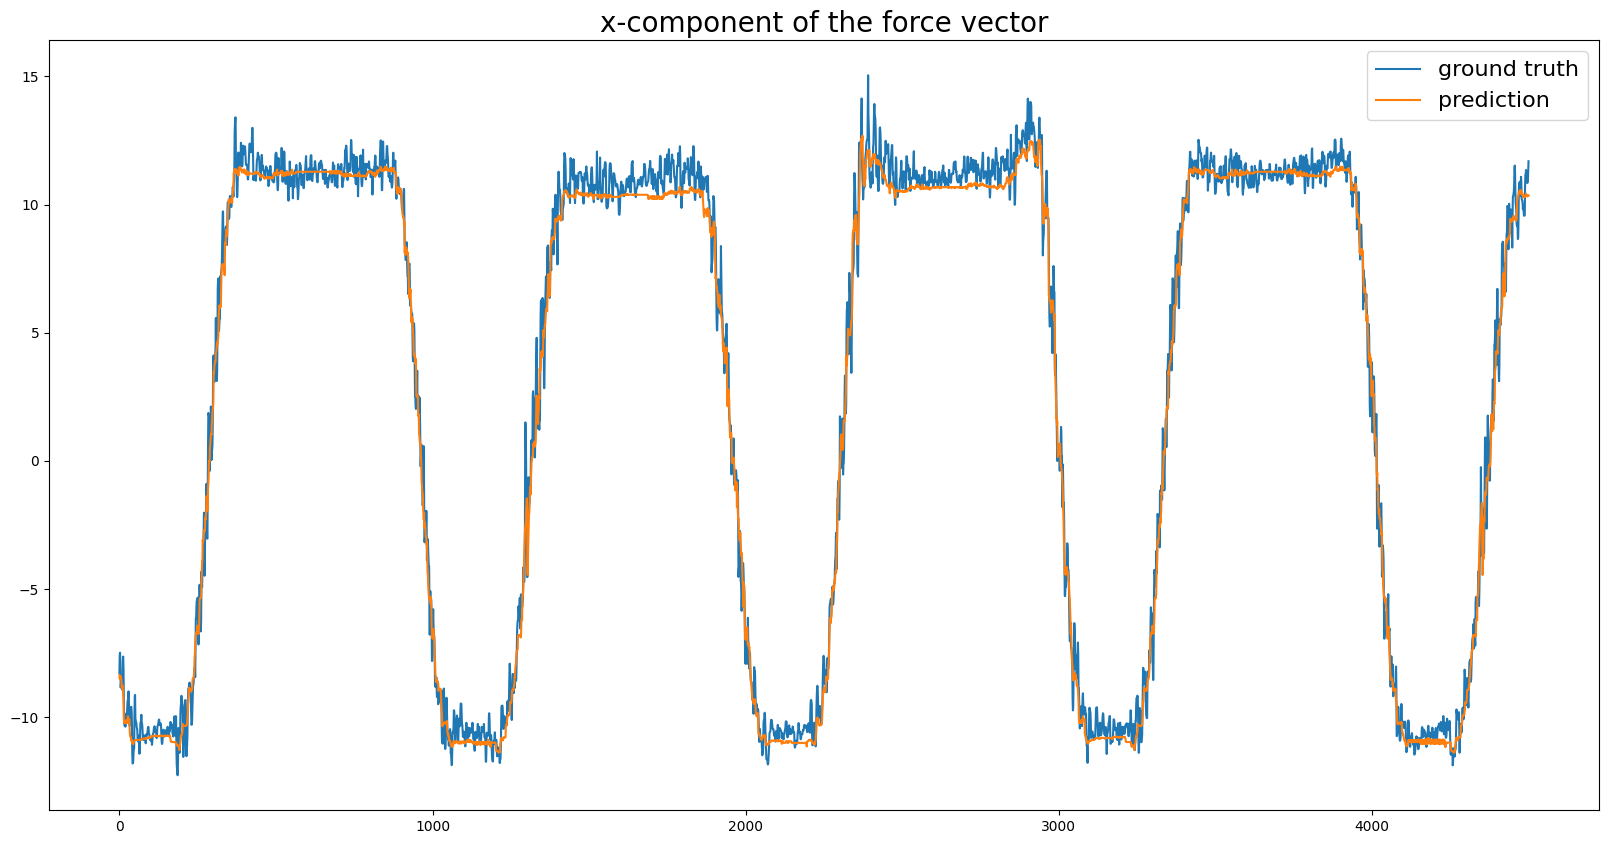

In [28]:
plt.subplots(figsize=(20, 10))

plt.title("x-component of the force vector", size=20)

plt.plot(f_x, label="ground truth")
plt.plot(predictions[:,0], label="prediction")

plt.legend(loc="upper right", fontsize=16)

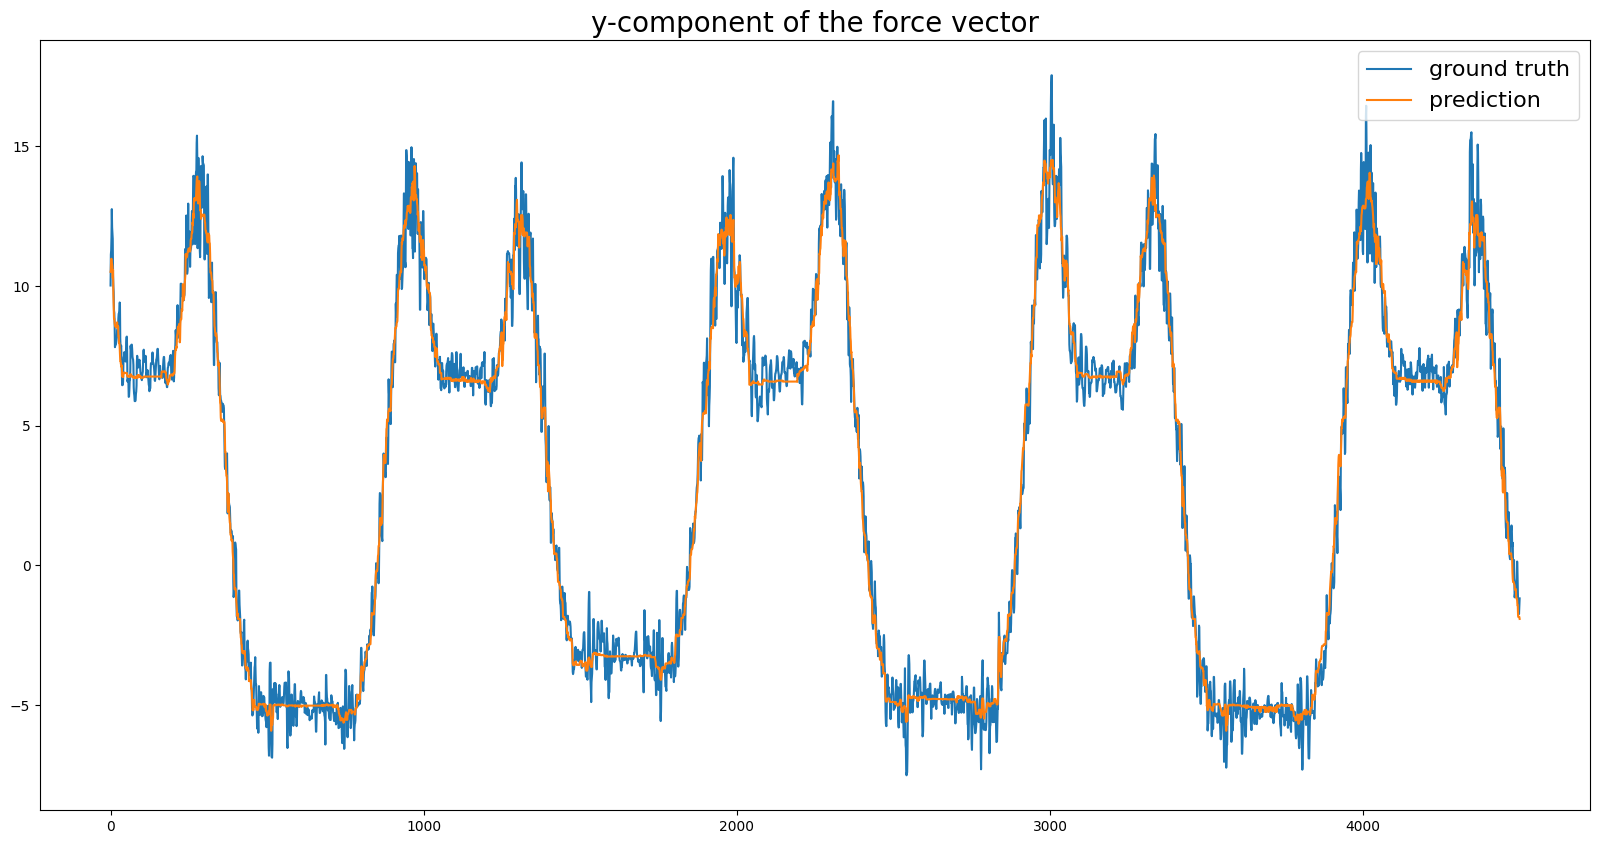

In [29]:
plt.subplots(figsize=(20, 10))

plt.title("y-component of the force vector", size=20)

plt.plot(f_y, label="ground truth")
plt.plot(predictions[:,1], label="prediction")

plt.legend(loc="upper right", fontsize=16)

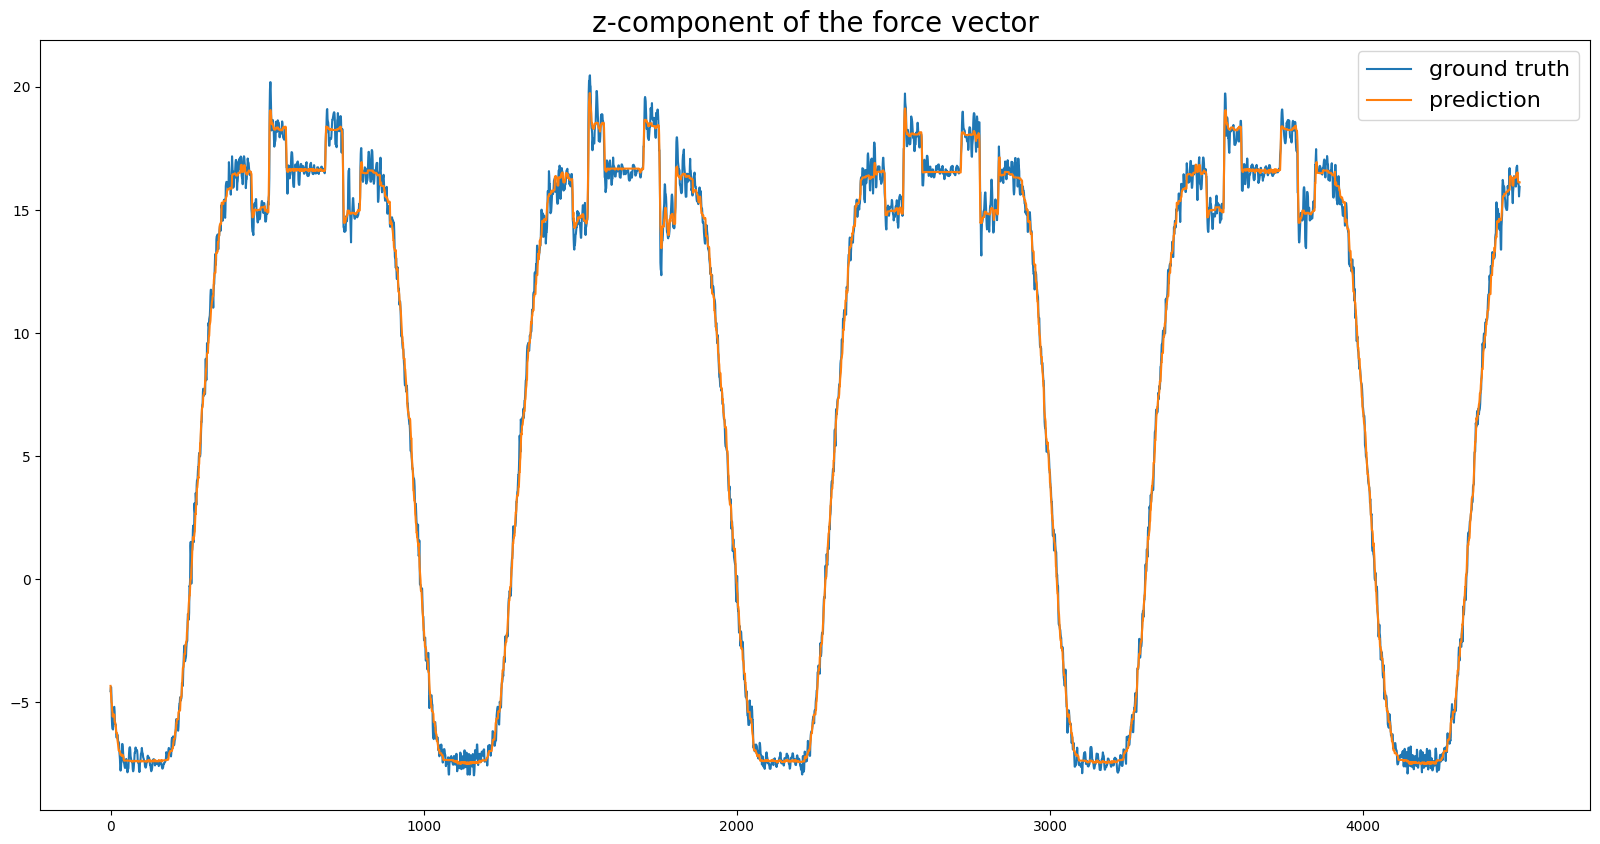

In [30]:
plt.subplots(figsize=(20, 10))

plt.title("z-component of the force vector", size=20)

plt.plot(f_z, label="ground truth")
plt.plot(predictions[:,2], label="prediction")

plt.legend(loc="upper right", fontsize=16)

### 2.9 Features

The most important feature looks as follows:

In [31]:
pipe1.features.to_sql()[pipe1.features.sort(by="importances")[0].name]

```sql
DROP TABLE IF EXISTS "FEATURE_1_3";

CREATE TABLE "FEATURE_1_3" AS
SELECT AVG( 
    CASE
        WHEN ( t2."4" > -0.563815 ) AND ( t2."8" > -5.915106 ) AND ( t2."4" > -0.560007 ) THEN -7.035334308806516
        WHEN ( t2."4" > -0.563815 ) AND ( t2."8" > -5.915106 ) AND ( t2."4" <= -0.560007 OR t2."4" IS NULL ) THEN -62.74602640372516
        WHEN ( t2."4" > -0.563815 ) AND ( t2."8" <= -5.915106 OR t2."8" IS NULL ) AND ( t1."10" > 0.262721 ) THEN -16.94725742676829
        WHEN ( t2."4" > -0.563815 ) AND ( t2."8" <= -5.915106 OR t2."8" IS NULL ) AND ( t1."10" <= 0.262721 OR t1."10" IS NULL ) THEN -12.11164189597631
        WHEN ( t2."4" <= -0.563815 OR t2."4" IS NULL ) AND ( t2."38" > -5.460974 ) AND ( t2."36" > -3.092528 ) THEN 5.036006845911339
        WHEN ( t2."4" <= -0.563815 OR t2."4" IS NULL ) AND ( t2."38" > -5.460974 ) AND ( t2."36" <= -3.092528 OR t2."36" IS NULL ) THEN -52.99309740580681
        WHEN ( t2."4" <= -0.563815 OR t2."4" IS NULL ) AND ( t2."38" <= -5.460974 OR t2."38" IS NULL ) AND ( t2."62" > -0.143896 ) THEN 0.473437318248295
        WHEN ( t2."4" <= -0.563815 OR t2."4" IS NULL ) AND ( t2."38" <= -5.460974 OR t2."38" IS NULL ) AND ( t2."62" <= -0.143896 OR t2."62" IS NULL ) THEN 77.8375239280841
        ELSE NULL
    END
) AS "feature_1_3",
       t1.rowid AS rownum
FROM "POPULATION__STAGING_TABLE_1" t1
INNER JOIN "DATA_ALL__STAGING_TABLE_2" t2
ON 1 = 1
WHERE t2."rowid" <= t1."rowid"
AND ( t2."rowid__30_000000" > t1."rowid" OR t2."rowid__30_000000" IS NULL )
GROUP BY t1.rowid;
```

As we can see, the predictions are very accurate. This suggests that it is very feasible to predict the force vector based on other sensor data.

### 2.9 Productionization

It is possible to productionize the pipeline by transpiling the features into production-ready SQL code. Please also refer to getML's `sqlite3` and `spark` modules.

In [32]:
# Creates a folder named robot_pipeline containing
# the SQL code.
pipe1.features.to_sql().save("robot_pipeline", remove=True)

In [33]:
# Creates a folder named containing the SQL code for Apache Spark.
pipe1.features.to_sql(dialect=getml.pipeline.dialect.spark_sql).save("robot_pipeline_spark", remove=True)

In [ ]:
getml.engine.shutdown()

## 3. Conclusion


The purpose of this notebook has been to illustrate the problem of the curse of dimensionality when engineering features from datasets with many columns.

The most important thing to remember is that this problem exists regardless of whether you engineer your features manually or using algorithms. Whether you like it or not: If you write your features in the traditional way, your search space grows quadratically with the number of columns.